## **1) Importing Python Packages for GAN**


In [ ]:
from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Dropout

# Import LeakyReLU directly from keras.layers
from keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
!mkdir generated_images

Pertama-tama saya mengimpor semua library yang dibutuhkan.
Saya menggunakan Keras untuk membangun model jaringan saraf (baik generator maupun discriminator).
Kemudian saya membuat folder bernama generated_images yang akan berfungsi untuk menyimpan hasil gambar palsu yang dihasilkan generator setiap beberapa epoch.

## **2) Parameters for Neural Networks & Data**

In [ ]:
img_width = 32
img_height = 32
channels = 3
img_shape = (img_width, img_height, channels)
latent_dim = 100
adam = Adam(learning_rate=0.0002)

Di bagian ini saya mendefinisikan ukuran gambar (32×32 piksel, 3 channel RGB), serta dimensi ruang laten (latent space) sebesar 100.
Nilai ini menentukan panjang vektor acak yang akan dimasukkan ke generator.
Saya juga mendefinisikan optimizer Adam dengan learning rate kecil agar proses training stabil.

## **3) Building Generator**





In [ ]:
def build_generator():
    model = Sequential()

    # Create first layer, to receive the input
    model.add(Dense(256 * 4 * 4, input_dim = latent_dim))
    # 256 * 8 * 8; for upscaling the layers,
    # initial shape to construct into final shape

    # Create default activation function
    model.add(LeakyReLU(alpha = 0.2))

    # Create reshape layer
    model.add(Reshape((4, 4,256)))
    # 8,8,256 ; reffers to first layer

    # Adding more layers for neurons and better result
    model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha= 0.2))
    model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha= 0.2))
    model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
    model.add(LeakyReLU(alpha= 0.2))
    # (4,4) >> filter size
    # strides = (2,2) >> Convolutional layers, that how NN understand images

    # Create Final output layer and forming image shape
    # the shape (3, (3,3)) reffers to image shape :
    #    >>>  img_shape = (img_width, img_height, channels)
    model.add(Conv2D(3, (3,3), activation= 'tanh', padding = 'same'))

    #
    model.summary()
    return model

generator = build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4096)           │       413,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 3)      │         3,459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

Pada tahap ini saya membangun generator, yaitu jaringan yang bertugas membuat gambar palsu dari vektor acak berukuran 100 dimensi.
Langkah-langkahnya:

Saya mulai dengan layer Dense besar yang menghasilkan 256 feature map berukuran 4×4.

Kemudian saya aktifkan neuron menggunakan LeakyReLU agar gradient tetap mengalir meskipun nilai negatif.

Saya ubah bentuknya menjadi (4×4×256) menggunakan Reshape.

Lalu saya lakukan upsampling bertahap dengan beberapa layer Conv2DTranspose untuk memperbesar dimensi gambar menjadi 8×8 → 16×16 → 32×32.

Di layer terakhir, saya gunakan aktivasi tanh karena hasilnya akan berada di rentang [-1, 1].
Dengan demikian, output generator adalah gambar berukuran 32×32 piksel dengan 3 channel warna.

## **4) Building Discriminator**

In [ ]:
def build_discriminator():
    model = Sequential()

    # Create input layer and filter and stride layer. That makes NN understand image
    model.add(Conv2D(64, (3,3), padding = 'same', input_shape = img_shape))

    # Adding activation function
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(128, (3,3), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2D(256, (3,3), padding = 'same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())

    model.add(Dropout(0.4))

    # Create output layer
    model.add(Dense(1, activation = 'sigmoid'))

    model.summary()
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,545 (2.98 MB)

 Trainable params: 780,545 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

Berikutnya saya membangun discriminator, yaitu model yang berperan sebagai “detektor keaslian gambar”.
Ia menerima gambar berukuran 32×32×3 dan memutuskan apakah gambar tersebut asli (1) atau palsu (0).
Saya menambahkan beberapa Conv2D layer dengan aktivasi LeakyReLU, diakhiri dengan Dropout 0.4 untuk mencegah overfitting, dan satu neuron output dengan sigmoid untuk mengembalikan probabilitas keaslian.

Setelah model dibuat, saya kompilasi discriminator dengan loss binary crossentropy dan Adam optimizer.

## **5) Connecting Neural Networks to build GAN**

In [ ]:
GAN = Sequential()
discriminator.trainable = False
GAN.add(generator)
GAN.add(discriminator)

GAN.compile(loss='binary_crossentropy', optimizer=adam)

In [ ]:
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 3)      │     1,466,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       780,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,246,660 (8.57 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 780,545 (2.98 MB)

Pada blok ini saya membentuk GAN (Generative Adversarial Network) dengan menggabungkan generator dan discriminator secara berurutan.
Namun sebelum itu, saya menonaktifkan training pada discriminator, karena saat melatih GAN, yang dioptimalkan hanyalah generator — tujuannya agar generator menjadi lebih baik dalam “menipu” discriminator.

## **6) Outputting Images**


In [ ]:
import matplotlib.pyplot as plt
import glob
import imageio
import PIL

save_name = 0.00000000

def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    global save_name
    save_name += 0.00000001
    # print("%.8f" % save_name)

    # Rescale images 0 - 1
    # gen_imgs = 0.5 * gen_imgs + 0.5
    gen_imgs = (gen_imgs + 1) / 2.0
    # gen_imgs = gen_imgs * 255

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("generated_images/%.8f.png" % save_name)
    plt.close()

Pada blok ini saya membentuk GAN (Generative Adversarial Network) dengan menggabungkan generator dan discriminator secara berurutan.
Namun sebelum itu, saya menonaktifkan training pada discriminator, karena saat melatih GAN, yang dioptimalkan hanyalah generator — tujuannya agar generator menjadi lebih baik dalam “menipu” discriminator.

## **7) Training GAN**

In [11]:
def train(epochs=100, batch_size=64, save_interval=20):
    # Ambil data CIFAR-10
    (X_train, _), (_, _) = cifar10.load_data()

    # Gunakan sebagian kecil data agar lebih cepat (opsional)
    X_train = X_train[:10000]

    # Normalisasi ke -1 sampai 1
    X_train = X_train / 127.5 - 1.

    bat_per_epo = int(X_train.shape[0] / batch_size)
    valid = np.ones((batch_size, 1))
    fakes = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for j in range(bat_per_epo):
            # Ambil batch acak dari data asli
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Hasil gambar palsu
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise, verbose=0)

            # Latih discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fakes)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Latih generator (ingin menipu discriminator)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = GAN.train_on_batch(noise, valid)

        # Cetak hasil tiap epoch
        print(f"Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Simpan gambar tiap interval tertentu
        if epoch % save_interval == 0 and epoch != 0:
            save_imgs(epoch)

# Jalankan training
train(epochs=100, batch_size=32, save_interval=10)

Epoch 1/100 [D loss: 1.1959, acc: 39.30%] [G loss: 0.2023]
Epoch 2/100 [D loss: 1.1976, acc: 39.29%] [G loss: 0.2016]
Epoch 3/100 [D loss: 1.1995, acc: 39.29%] [G loss: 0.2008]
Epoch 4/100 [D loss: 1.2014, acc: 39.30%] [G loss: 0.2001]
Epoch 5/100 [D loss: 1.2033, acc: 39.29%] [G loss: 0.1993]
Epoch 6/100 [D loss: 1.2055, acc: 39.29%] [G loss: 0.1985]
Epoch 7/100 [D loss: 1.2078, acc: 39.29%] [G loss: 0.1976]
Epoch 8/100 [D loss: 1.2102, acc: 39.29%] [G loss: 0.1967]
Epoch 9/100 [D loss: 1.2127, acc: 39.30%] [G loss: 0.1958]
Epoch 10/100 [D loss: 1.2152, acc: 39.30%] [G loss: 0.1949]
Epoch 11/100 [D loss: 1.2178, acc: 39.30%] [G loss: 0.1939]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Epoch 12/100 [D loss: 1.2205, acc: 39.30%] [G loss: 0.1930]
Epoch 13/100 [D loss: 1.2232, acc: 39.30%] [G loss: 0.1920]
Epoch 14/100 [D loss: 1.2260, acc: 39.30%] [G loss: 0.1911]
Epoch 15/100 [D loss: 1.2288, acc: 39.30%] [G loss: 0.1901]
Epoch 16/100 [D loss: 1.2317, acc: 39.30%] [G loss: 0.1891]
Epoch 17/10

In [12]:
noise = np.random.normal(0, 1, (1,latent_dim))
gen_imgs = generator.predict(noise)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


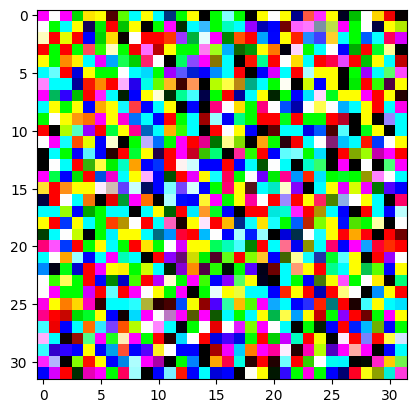

In [13]:
gen_imgs = (gen_imgs + 1) / 2.0
plt.imshow(gen_imgs[0])

Pada bagian ini saya mengambil dataset CIFAR-10, yang berisi gambar 32×32 dari 10 kategori objek.
Saya hanya menggunakan sebagian data (10.000 gambar) untuk mempercepat proses.
Selanjutnya, saya normalisasi ke rentang [-1,1] agar sesuai dengan output tanh di generator.
Saya juga membuat label valid = 1 untuk gambar asli dan fakes = 0 untuk gambar palsu.

lalu saya menjalankan proses pelatihan dua tahap di setiap batch:

Melatih discriminator untuk membedakan antara gambar asli (imgs) dan palsu (gen_imgs).

Melatih generator agar mampu menipu discriminator dengan menghasilkan gambar yang terlihat lebih realistis.

Saya menghitung rata-rata discriminator loss (d_loss) dari kedua jenis gambar dan menyimpan nilai generator loss (g_loss).

Setiap epoch, saya menampilkan nilai loss dan akurasi discriminator, serta loss dari generator.
Kemudian setiap beberapa epoch (misalnya setiap 10 epoch), saya memanggil save_imgs() untuk melihat perkembangan hasil gambar dari waktu ke waktu.

Setelah training selesai, saya menghasilkan satu gambar dari noise acak dan menampilkannya.
Gambar ini merupakan contoh hasil “pemikiran” generator setelah belajar selama ratusan epoch.

### **8) Making GIF**

In [14]:
# Display a single image using the epoch number
# def display_image(epoch_no):
#   return PIL.Image.open('generated_images/%.8f.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

  if filenames:  # Check if filenames is not empty
    image = imageio.imread(filenames[-1])
    writer.append_data(image)

/tmp/ipython-input-360815478.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-360815478.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])


Terakhir, saya membuat animasi GIF dari seluruh gambar hasil training yang disimpan di folder generated_images.
Tujuannya agar saya bisa melihat evolusi kualitas gambar dari epoch awal hingga akhir — biasanya gambar awal terlihat acak, lalu perlahan-lahan mulai membentuk pola yang menyerupai objek nyata dari dataset CIFAR-10.